In [11]:
import torch
from torch import nn
from torch.nn import parameter
from torch.utils import data
import torchvision
from torchvision import datasets
from d2l import torch as d2l

# 多层感知机的从零开始实现

In [86]:
batch_size = 256
train_iter, valid_iter = d2l.load_data_fashion_mnist(batch_size)

### 初始化模型参数

In [87]:
num_input, num_output, num_hidden = 28 * 28, 10, 256

W1 = parameter.Parameter(torch.randn(num_input, num_hidden, requires_grad=True) * 0.01)
b1 = parameter.Parameter(torch.zeros(num_hidden, requires_grad=True))
W2 = parameter.Parameter(torch.randn(size=(num_hidden, num_output), requires_grad=True) * 0.01)
b2 = parameter.Parameter(torch.zeros(size=(num_output,), requires_grad=True))

params = [W1, b1, W2, b2]

### 构建模型

In [88]:
def relu(X):
    return torch.max(X, torch.zeros_like(X))

In [89]:
def net(X):
    X = X.reshape((-1, num_input))
    h = relu(X@W1 + b1)
    return h@W2 + b2

In [90]:
loss = nn.CrossEntropyLoss(reduction='none')

### 训练

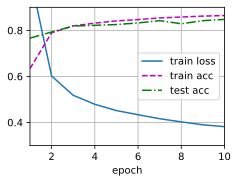

In [91]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, valid_iter, loss, num_epochs, updater)

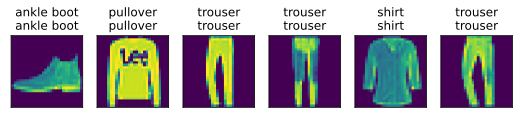

In [92]:
d2l.predict_ch3(net, valid_iter)

# 多层感知机的简洁实现

### 模型

In [93]:
lr, num_epochs = 0.05, 10

net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256), nn.ReLU(),
    nn.Linear(256, 10)
)

def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weight)


loss = nn.CrossEntropyLoss()

trainer = torch.optim.SGD(net.parameters(), lr=lr)


for epoch in range(num_epochs):
    net.train()
    for X, y in train_iter:
        trainer.zero_grad()
        l = loss(net(X), y)
        l.backward()
        trainer.step()

    net.eval()
    with torch.no_grad():
        train_acc, valid_acc = d2l.evaluate_accuracy(net, train_iter), d2l.evaluate_accuracy(net, valid_iter)
        if (epoch + 1) % 2 == 0:
            print(f"epoch {epoch + 1}, train acc={train_acc:.3f}, valid acc={valid_acc:.3f}, train loss = {l:.3f}")


epoch 2, train acc=0.777, valid acc=0.765, train loss = 0.595


KeyboardInterrupt: 

# 权重衰退

### 从零开始实现

In [ ]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [ ]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]


def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [ ]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

train(lambd=0)
train(lambd=3)

### 简洁实现

In [ ]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    def init_weight(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight)
    net.apply(init_weight)

    num_epochs, lr = 100, 0.003
    loss = nn.MSELoss()
    trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            print(f'epoch {epoch + 1}, train loss={d2l.evaluate_loss(net, train_iter, loss)}, valid loss={d2l.evaluate_loss(net, test_iter, loss)}')

train_concise(3)

# 丢弃法

### 从零开始实现

In [ ]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [ ]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [ ]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_traing=True) -> None:
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_traing
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape(-1, self.num_inputs)))
        if self.training:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out
    
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)


In [ ]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 简洁实现

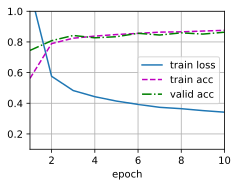

In [ ]:
num_epochs, lr, batch_size = 10, 0.5, 256
train_iter, valid_iter = d2l.load_data_fashion_mnist(batch_size)

dropout1, dropout2 = 0.2, 0.5

net = nn.Sequential(nn.Flatten(),
                    nn.Linear(28 * 28, 256), nn.ReLU(), nn.Dropout(dropout1),
                    nn.Linear(256, 256), nn.ReLU(), nn.Dropout(dropout2),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

trainer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')

animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 1.0], legend=['train loss', 'train acc', 'valid acc'])
for epoch in range(num_epochs):
    net.train()
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        trainer.zero_grad()
        y_hat = net(X)
        l = loss(y_hat, y)
        l.mean().backward()
        trainer.step()
        metric.add
        metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
    l, train_acc = metric[0] / metric[2], metric[1] / metric[2]
    
    valid_acc = d2l.evaluate_accuracy(net, valid_iter)
    animator.add(epoch + 1, (l, train_acc) + (valid_acc,))

# 实战Kaggle比赛：预测房价

### 下载和缓存数据集

In [12]:
import hashlib
import os
import tarfile
import zipfile
import requests
import numpy as np
import pandas as pd

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [13]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [14]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [15]:
DATA_HUB['kaggle_house_train'] = ( DATA_URL + 'kaggle_house_pred_train.csv', '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = ( DATA_URL + 'kaggle_house_pred_test.csv', 'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [16]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [17]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [18]:
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


### 数据预处理

In [19]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [20]:
all_features = pd.get_dummies(all_features, dummy_na=True)

In [21]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

### 网络构建

In [22]:
loss = nn.MSELoss()
in_features = train_features.shape[1]


def get_net():
    # net = nn.Sequential(nn.Linear(in_features,1))
    net = nn.Sequential(
        nn.Linear(in_features, 128), nn.ReLU(), 
        nn.Linear(128, 32), nn.ReLU(),
        nn.Linear(32, 1)
    )

    def init_weight(m):
        if type(m) == nn.Linear:
            nn.init.xavier_normal_(m.weight)
    net.apply(init_weight)
    return net


def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [23]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### K折交叉验证

In [24]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [25]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, 验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.061920, 验证log rmse0.139064
折2，训练log rmse0.042548, 验证log rmse0.156577
折3，训练log rmse0.053162, 验证log rmse0.173740
折4，训练log rmse0.049909, 验证log rmse0.140317
折5，训练log rmse0.048963, 验证log rmse0.170621
5-折验证: 平均训练log rmse: 0.051300, 平均验证log rmse: 0.156064


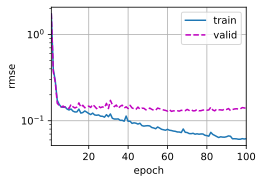

In [26]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.05, 1e-3, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 平均验证log rmse: {float(valid_l):f}')

### 提交数据

In [27]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.057576


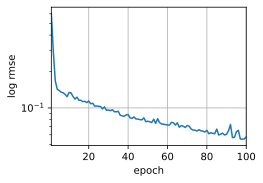

In [28]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)